# Leaky Integrate-and-Fire Model

Basic spiking models with an exogenous spiking mechanism. These models are solutions for the tutorials in Chapter 2 from Miller, 2018 (see *References*).

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Model Description

The model is completely described by the leaky integration differential equation: 

$$C_m \dfrac{dV_m(t)}{dt} = G_L(E_L - V_m(t)) + I_{app}$$

or, equivalently:

$$C_m \dfrac{dV_m(t)}{dt} = \dfrac{(E_L - V_m(t))}{R_L} + I_{app}$$


And the exogenous spiking mechanism: 

$$ V_m = V_{reset}$$ whenever $V_m > V_{th}$

Where: 

- $C_m$ is the membrane's capacitance
- $V_m$ is the membrane's potential 
- $G_L$ is the leak conductance ($R_L$ the leak resistance)
- $E_L$ is the reverse potential of the leak potential
- $I_{app}$ is the externally applied current
- $V_{reset}$ is the reset value of the membrane's potential after a spike
- $V_{th}$ is the potential threshold for a spike 

More details into the biophysical motivation for the model are found in Chapter 2 from Miller, 2018.

### Euler's method

The update rule for simulating the model via Euler's method is given by:

$$ V_m(t + \Delta t) = V_m(t) + \Delta t \dfrac{G_L(E_L - V_m(t)) + I_{app}}{C_m} $$

## Simulations

In [3]:
def update_V_m(prev_V_m, timestep, G_L, E_L, C_m, I_app, noise_std):
    """
    Performs update for membrane's potential using Euler's method
    The noise std is the standard deviation of the noise term (see below)
    """
    noise_term = np.random.randn(1) * noise_std
    return prev_V_m + (timestep*(G_L*(E_L - prev_V_m) + I_app) / C_m) + noise_term*np.sqrt(timestep)

def simulate(I_app, t_max=2000, timestep=0.1, G_L=(1/5), E_L=-70, 
             C_m=2, V_th=-50, V_reset=-65, noise_std=0):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    V_m[0] = E_L
    I = np.zeros(len(t)) + I_app
    spikes = np.zeros(len(t)).astype(int)
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, I[i], noise_std)
        if V_m[i] > V_th:
            # There is a spike in this case
            spikes[i] = 1
            V_m[i] = V_reset

    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "firing_rate": firing_rate}

def plot_results(results_dict, t_min=100, t_max=300):
    fig, ax = plt.subplots(3,1, figsize=(10,18))
    ax[0].plot(results_dict["t"], results_dict["I"])
    ax[0].set_xlim((t_min, t_max))
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("Current", fontsize=12)
    ax[1].plot(results_dict["t"], results_dict["V_m"])
    ax[1].set_xlim((t_min, t_max))
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("Membrane's potential", fontsize=12)
    spike_times = results_dict["t"][results_dict["spike_train"].astype(bool)]
    ax[2].eventplot(spike_times)
    ax[2].set_xlim((t_min, t_max))
    ax[2].set_xlabel("t (ms)", fontsize=12)
    ax[2].set_ylabel("Spikes", fontsize=12)
    plt.tight_layout()
    plt.show()    

### Minimum spiking current

Given the baseline parameters defined in the function, the minimum current that will produce a spike is given by:

$$ I_{th} =G_L(V_{th} - E_L) $$

We confirm this via simulation

In [3]:
min_current = (1/5)*(-50 + 70)
spike_results = simulate(min_current + 1)
no_spike_results = simulate(min_current - 1)

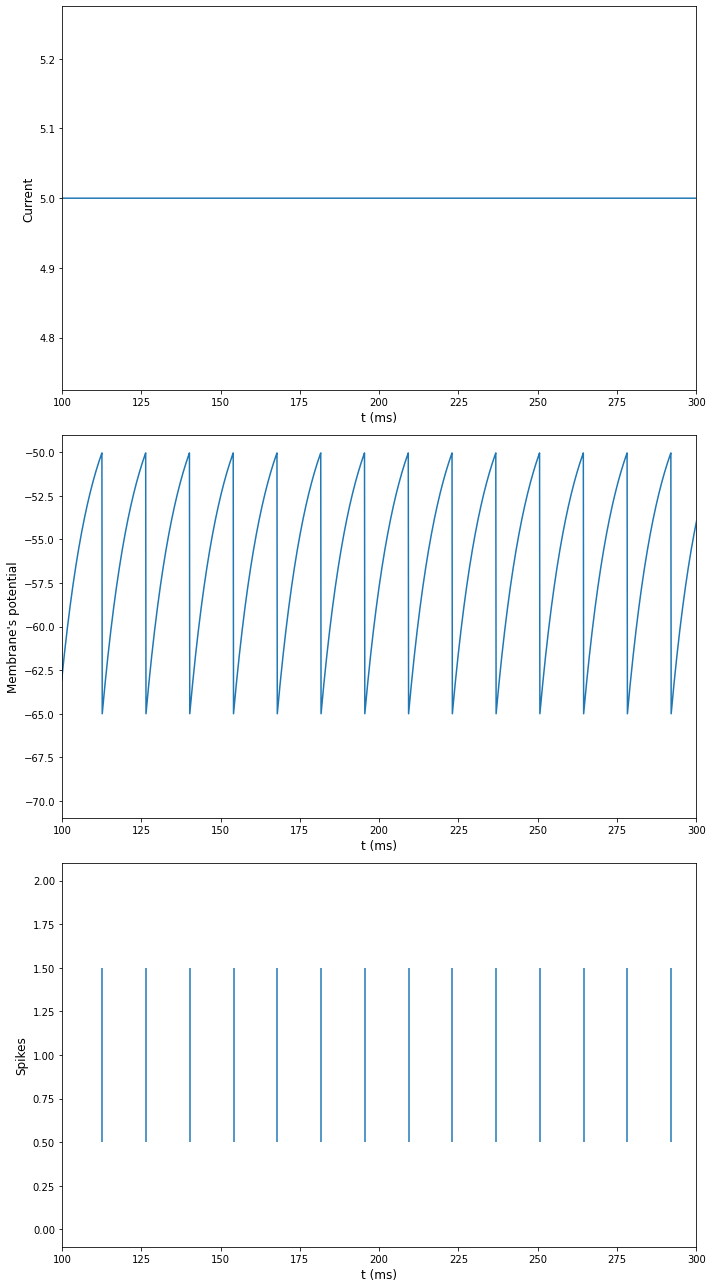

In [4]:
plot_results(spike_results)

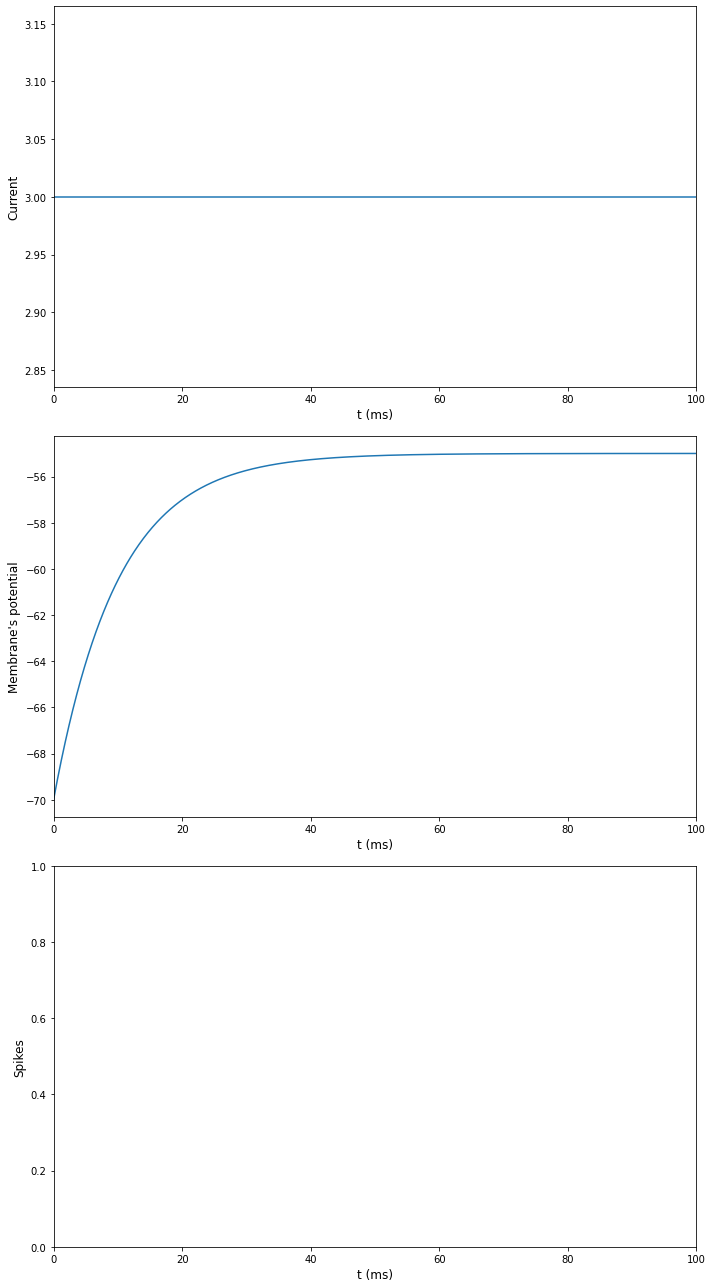

In [5]:
plot_results(no_spike_results, 0, 100)

### Firing rate and f-I Curve

The firing rate (spikes per ms.) is given by the spike count divided by the trial time (in ms). To convert to Hz (event / sec) we only multiply that rate by 1000.

The analytical solution is given by:

$$ f = \dfrac{1}{ISI}$$

Where $ISI$ is the interspike interval time and is given by:

$$ ISI = \tau_m ln(I_{app} R_m + E_L - V_{reset}) - \tau_m ln(I_{app} R_m + E_L - V_{th})$$

With $tau_m = \dfrac{C_m}{G_L}$

Note: given the parameters units defined above, this rate is in event / ms. Multiply by 1000 to convert to Hz

In [6]:
def get_f_I_curve(I_app, G_L=(1/5), E_L=-70, C_m=2, V_th=-50, V_reset=-65):
    # Create some variables to make notation the same as in equation above
    tau_m = C_m / G_L
    R_m = 1 / G_L
    # The two terms inside the log can be negative if current is small enough
    # In those cases we need to manually set the firing rate to zero instead
    term1 = I_app * R_m + E_L - V_reset
    term2 = I_app * R_m + E_L - V_th
    negative_log_mask = (term1 <= 0) | (term2 <= 0)
    return 1000 * np.where(negative_log_mask, 0,
                    1/(tau_m * np.log(term1) - tau_m * np.log(term2)))

In [7]:
# Simulated curve
I_trials = np.linspace(min_current - 1, min_current + 2, 20)
firing_rates = []
for I_app in I_trials:
    firing_rates.append(simulate(I_app)["firing_rate"])

In [8]:
# Analytical curve
fI_curve = get_f_I_curve(I_trials)

<ipython-input-6-dd6402662e14>:11: RuntimeWarning: invalid value encountered in log
  1/(tau_m * np.log(term1) - tau_m * np.log(term2)))


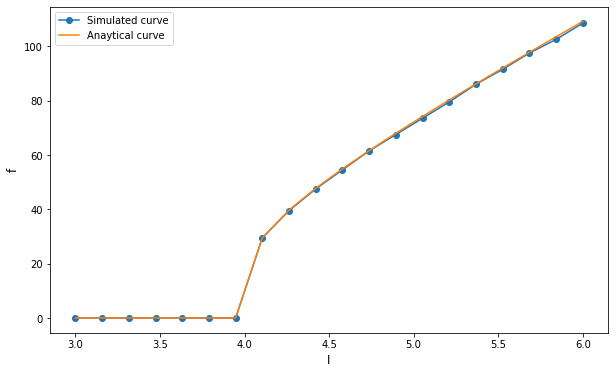

In [9]:
plt.figure(figsize=(10,6))
plt.plot(I_trials, firing_rates, marker = "o",label="Simulated curve")
plt.plot(I_trials, fI_curve, label="Anaytical curve")
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

### Simulation with noise

We add a Gaussian noise term with mean 0 and variance $\sigma_I^2$ to the changes in membrane's potential.

The update rule for Euler's method is now:

$$ V_m(t + \Delta t) = V_m(t) + \Delta t \dfrac{G_L(E_L - V_m(t)) + I_{app}}{C_m}  + \epsilon_t \sqrt{\Delta t}$$

with $\epsilon_t \sim N(0, \sigma_I^2)$

In [10]:
# Simulated curve
sigma_values = [0, 0.1, 0.5, 1]
firing_rates = {}
for current_sigma in sigma_values:
    firing_rates[f"$\sigma_I = {current_sigma}$"] = []
    for I_app in I_trials:
        firing_rates[f"$\sigma_I = {current_sigma}$"].append(simulate(I_app, noise_std=current_sigma)["firing_rate"])

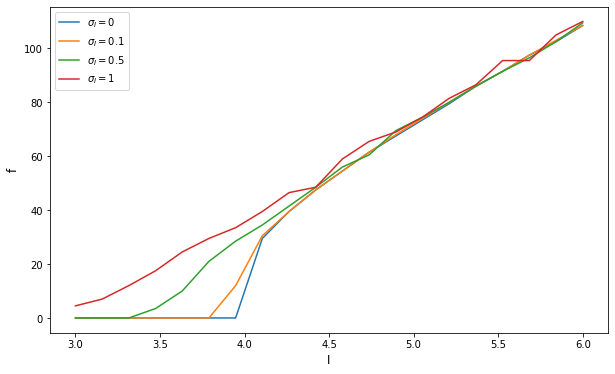

In [11]:
plt.figure(figsize=(10,6))
for sigma_value in firing_rates:
    plt.plot(I_trials, firing_rates[sigma_value],label=sigma_value)
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

Increasing the voltage noise makes the firing rate to increase more linearly with respect to the applied current.

We confirm this finding by using a higer resolution of the timestep.

In [12]:
# Simulated curve
sigma_values = [0, 1]
firing_rates = {}
for current_sigma in sigma_values:
    firing_rates[f"$\sigma_I = {current_sigma}$"] = []
    for I_app in I_trials:
        firing_rates[f"$\sigma_I = {current_sigma}$"].append(simulate(I_app, timestep = 0.01,noise_std=current_sigma)["firing_rate"])

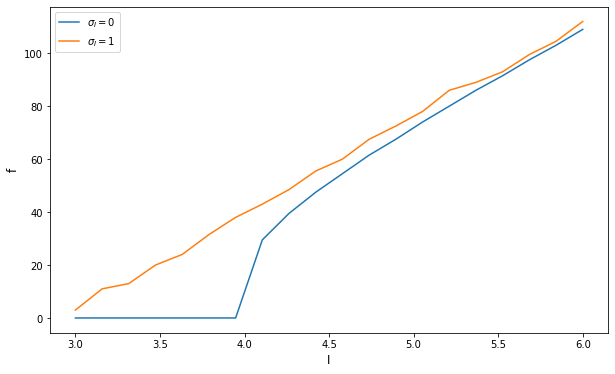

In [13]:
plt.figure(figsize=(10,6))
for sigma_value in firing_rates:
    plt.plot(I_trials, firing_rates[sigma_value],label=sigma_value)
plt.legend()
plt.xlabel("I", fontsize=12)
plt.ylabel("f", fontsize=12)
plt.show()

Intuitively this result makes sense because the added noise to the voltage differential equation enables spikes even when the current would be too low to cross the threshold in the absence of noise. Thus a noise with high variance allows the voltage to reach the spiking threshold even if the current is low. This in turn, removes the discontinuity of the firing rate at $I_{th}$

### Refractory Period

We consider three approaches to integrate a refractory period into the Leaky Integrate-and-Fire model. These approaches are described in more detail in Chapter 2 of Miller, 2018.

For the different approaches we consider the base model established above (without noise) and parameters values given by: 

$E_L = -70, R_m = 100, C_m = 0.1$

We consider different scenarios with different values of external current applied ranging from $I_{app}= 0.1$ (or 100 pA) to $I_{app} = 0.6$ (or 600 pA). We simulate the application of the current for a total duration of 2s

#### Forced Voltage Clamp

This approach considers a fixed threshold, $V_{th}=-50$, and reset potential, $V_{reset}=-65$. Whenever the potential exceeds the threshold, we set $V_m = V_{reset}$ and fix it in that value for $\tau_{ref} = 2.5 $ ms after the spike. After that time has passed since the last spike, $V_m$ again evolves according to the differential equation of the model.

In [38]:
def simulate_forced_clamp(I_app, t_max=2000, timestep=0.1, G_L=(1/100), E_L=-70, 
                          C_m=0.1, V_th=-50, V_reset=-65, noise_std=0, tau_ref=2.5):
    # Adapted from simulate function from above
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    V_m[0] = E_L
    I = np.zeros(len(t)) + I_app
    spikes = np.zeros(len(t)).astype(int)
    interspike_timer = 0
    in_refractory = False # Flag for refractory period
    for i in range(1,len(t)):
        if in_refractory:
            V_m[i] = V_reset
            interspike_timer += timestep
            if interspike_timer > tau_ref:
                in_refractory = False
                interspike_timer = 0
        else:
            V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, I[i], noise_std)
            if V_m[i] > V_th:
                # There is a spike in this case
                spikes[i] = 1
                in_refractory = True
            
    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "spike_times": t[spikes.astype(bool)],
            "mean_potential": V_m.mean(),
            "firing_rate": firing_rate}

First run the simulation for a couple of example currents: $I_{app} = .22$ and $I_{app}=.6$ 

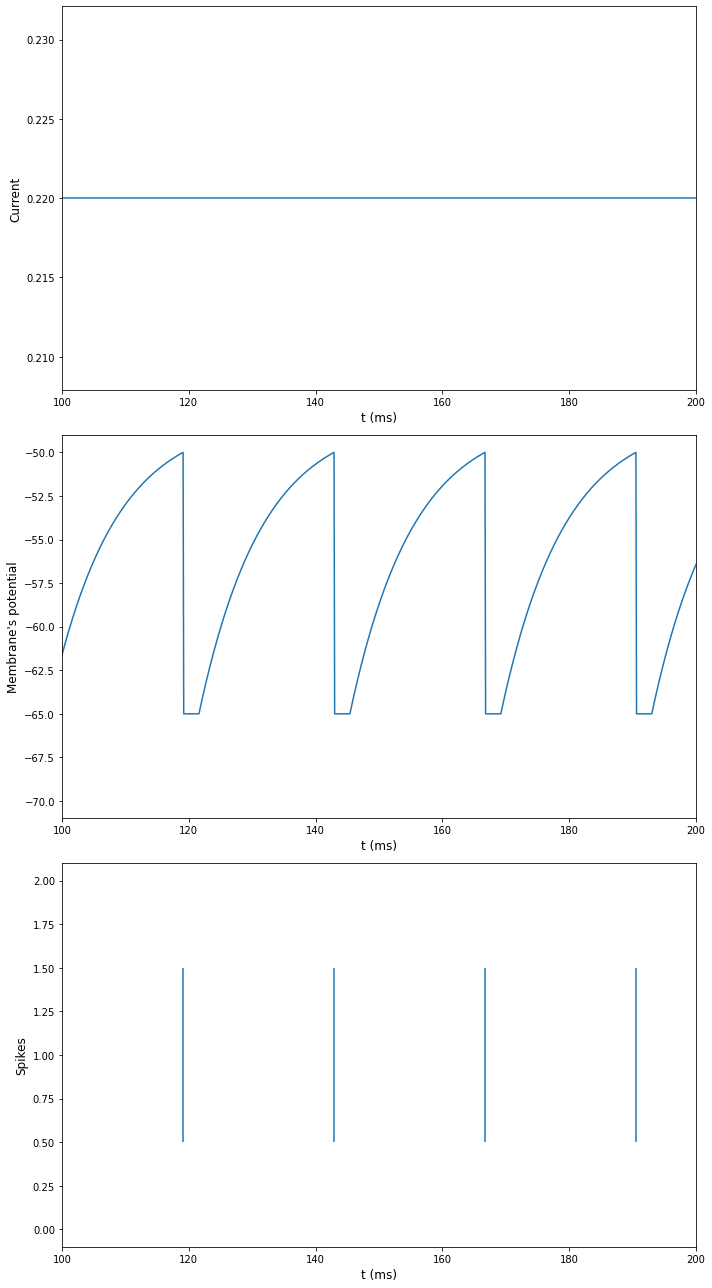

In [39]:
sim_results = simulate_forced_clamp(0.22)
plot_results(sim_results, t_min=100, t_max=200)

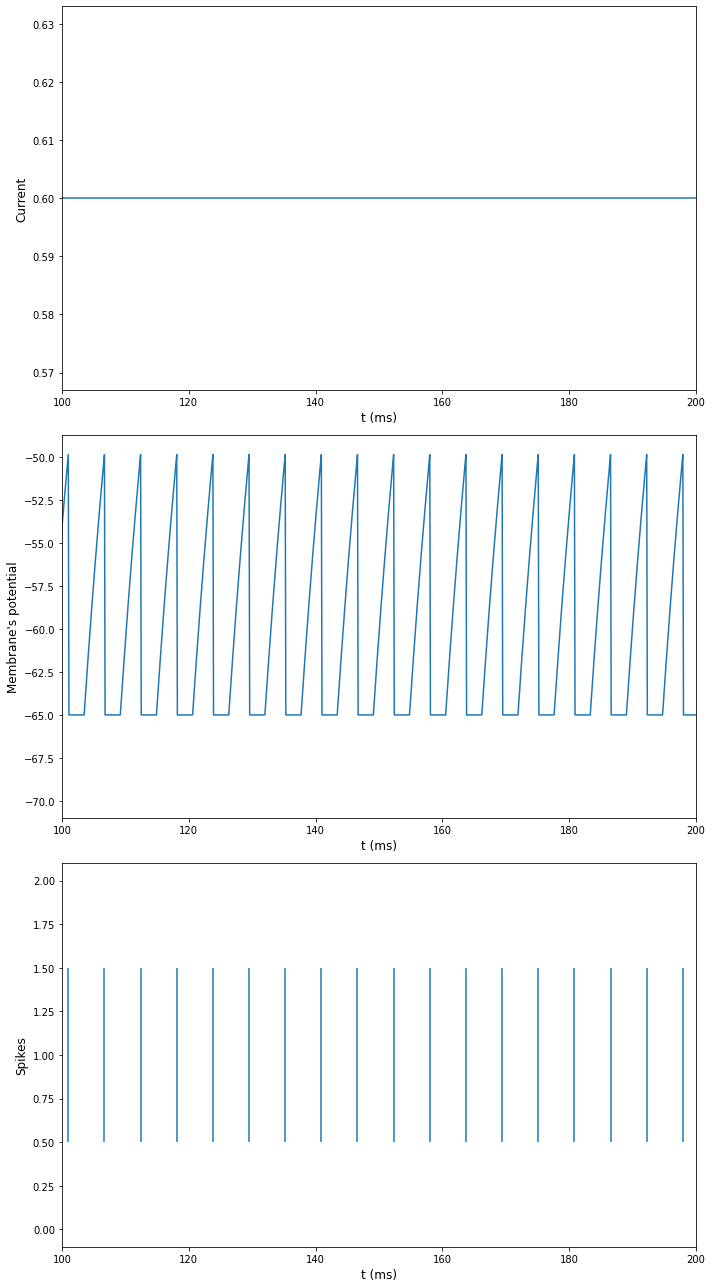

In [40]:
sim_results = simulate_forced_clamp(0.6)
plot_results(sim_results, t_min=100, t_max=200)

In [41]:
# Collect results for a range of currents
I_range = np.linspace(0.1, 0.6, 50)
firing_rates_forced_clamp = []
mean_potential_forced_clamp = []
for I_app in I_range:
    sim_results = simulate_forced_clamp(I_app)
    firing_rates_forced_clamp.append(sim_results["firing_rate"])
    mean_potential_forced_clamp.append(sim_results["mean_potential"])

#### Threshold Increase

In this case, the spike threshold, $V_{th}$ is dynamic following the equation:

$$ \dfrac{dV_{th}(t)}{ dt} = \dfrac{V_{th}^{(0)} - V_{th}(t)}{\tau_{Vth}}$$

Where the baseline threshold, $V_{th}^{(0)} = -50$ is also the initial value of the threshold trajectory: $V_{th}(0)=V_{th}^{(0)}$. We set the refractory time constant to: $\tau_{Vth} = 1$.

$V(t)$ and $V_{th}(t)$ follow the dynamics from the model's equations, but whenever $V(t) > V_{th}(t)$, there is a spike and we set $V_m = V_{reset}$ and $V_{th} = V_{th}^{(max)} = 200$

In [156]:
def update_V_th(prev_V_th, timestep, tau_Vth, V_th_base):
    return prev_V_th + timestep*(V_th_base - prev_V_th)/tau_Vth

def simulate_threshold_increase(I_app, t_max=2000, timestep=0.1, G_L=(1/100), E_L=-70, 
                                C_m=0.1, V_th_base=-50, V_th_max = 200, V_reset=-65, 
                                noise_std=0, tau_Vth=1):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    V_th = np.zeros(len(t))
    V_m[0] = E_L
    V_th[0] = V_th_base
    I = np.zeros(len(t)) + I_app
    spikes = np.zeros(len(t)).astype(int)
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, I[i], noise_std)
        V_th[i] = update_V_th(V_th[i-1], timestep, tau_Vth, V_th_base)
        if V_m[i] > V_th[i]:
            # There is a spike in this case
            spikes[i] = 1
            V_m[i] = V_reset
            V_th[i] = V_th_max

    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "V_th": V_th,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "spike_times": t[spikes.astype(bool)],
            "mean_potential": V_m.mean(),
            "firing_rate": firing_rate}

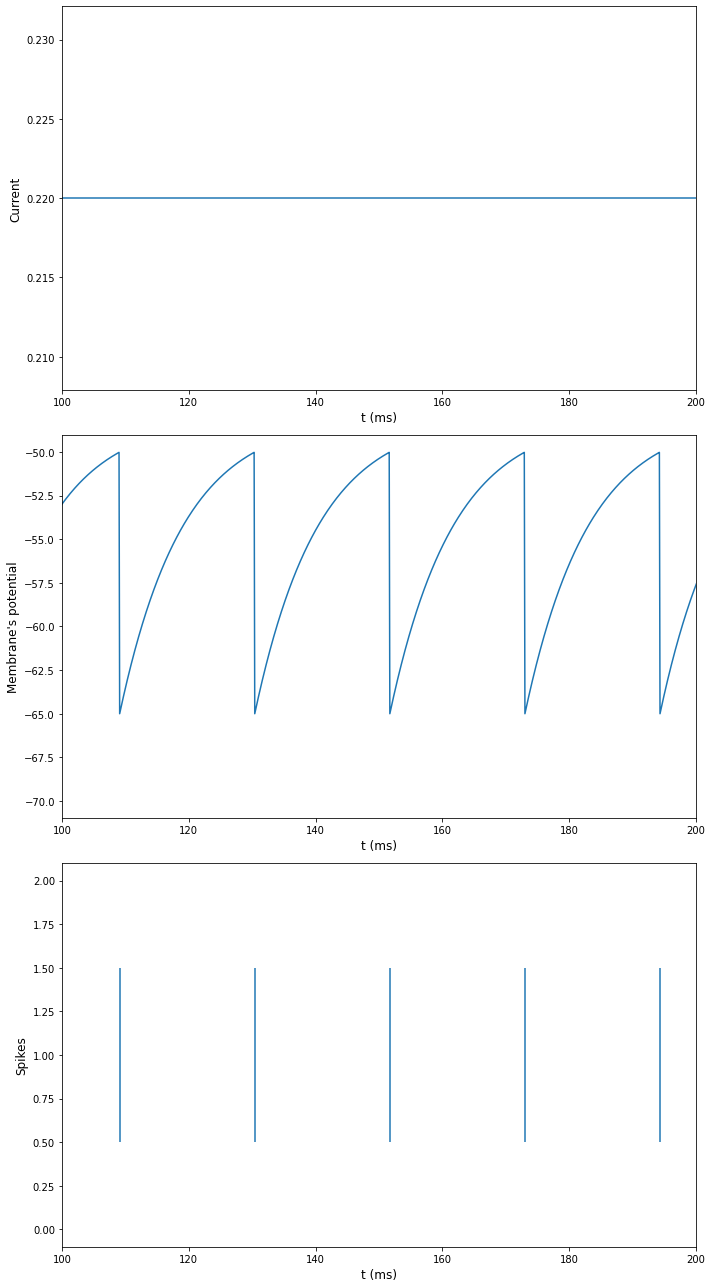

In [44]:
# Simulate for I_app = 0.22
sim_results = simulate_threshold_increase(0.22)
plot_results(sim_results, t_min=100, t_max=200)

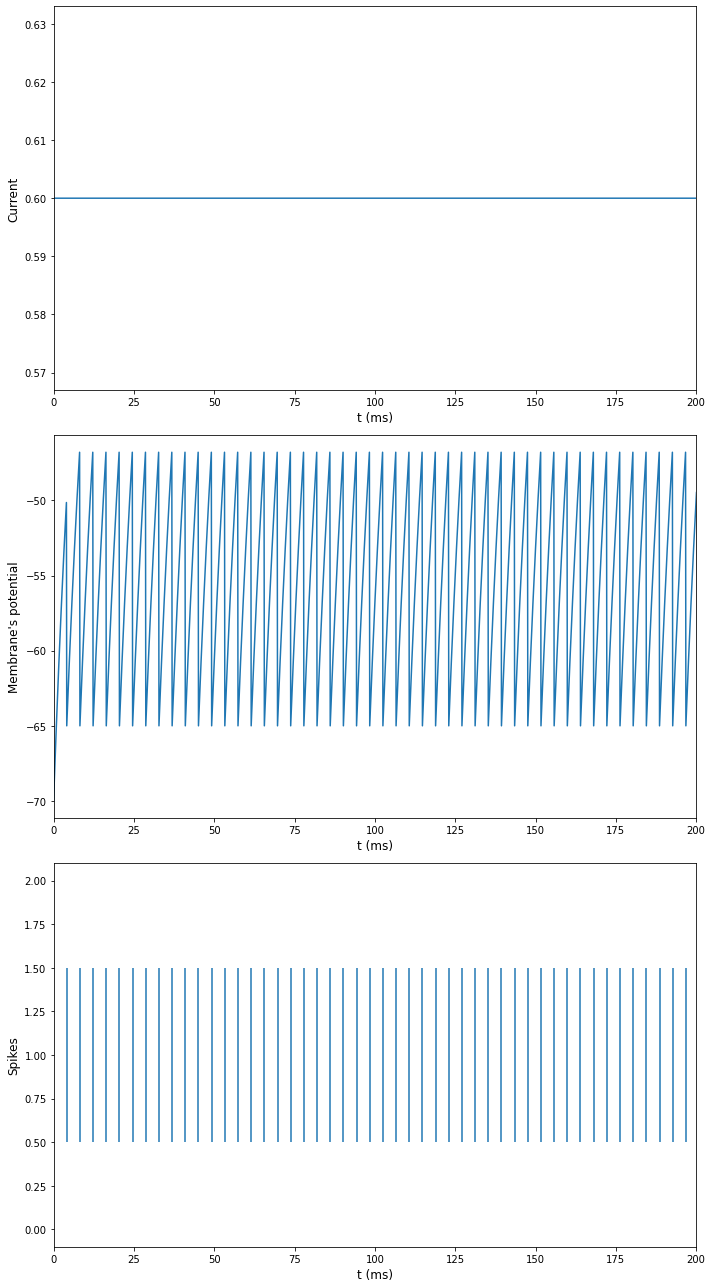

In [45]:
# Simulate for I_app = 0.6
sim_results = simulate_threshold_increase(0.6)
plot_results(sim_results, t_min=0, t_max=200)

In [46]:
# Collect results for a range of currents
firing_rates_threshold_increase = []
mean_potential_threshold_increase = []
for I_app in I_range:
    sim_results = simulate_threshold_increase(I_app)
    firing_rates_threshold_increase.append(sim_results["firing_rate"])
    mean_potential_threshold_increase.append(sim_results["mean_potential"])

<a id='refractory_conductance'></a>

#### Refractory Conductance with Threshold Increase

In this model, we add a potassium conductance term to the differential equation on $V_m(t)$ which is now given by:

$$C_m \dfrac{dV_m(t)}{dt} = G_L(E_L - V_m) + I_{app} + G_{ref}(t)(E_K - V_m(t))$$

Additionally, the refractory conductance evolves according to: 

$$ \dfrac{dG_{ref}(t)}{dt} = - \dfrac{G_{ref}(t)}{\tau_{Gref}} $$

We set $E_K = -80$ and $\tau_{Gref} = 0.2$ and the initial value for the refractory conductance to zero: $G_{ref}(0) = 0$.

Additionally, whenever there is a spike, we automatically increase the refractory conductance to: $G_{ref} = G_{ref} + \Delta G$, with $\Delta G = 2$

We keep the threshold dynamics as in the previous model (with the same equation and same values for $V_{th}^{(0)}$ and $V_{th}^{(max)}$). 

However, Whenever there is a spike ($V_m(t) > V_{th}(t)$), we do not set $V_m(t)$ to its reset value but rather let it decrease endogenously as a consequence of the sudden increase in $G_{ref}$ at the spike time.


In [153]:
def update_G_ref(prev_G_ref, timestep, tau_Gref):
    return prev_G_ref - timestep * prev_G_ref / tau_Gref

def update_V_m(prev_V_m, timestep, G_L, E_L, C_m, I_app, G_ref, E_K):
    # For easier readability we compute each term separately
    leak_term = G_L*(E_L - prev_V_m)
    refractory_term = G_ref*(E_K - prev_V_m)
    return prev_V_m + (timestep*(leak_term + refractory_term + I_app) / C_m)

def simulate_refractory_conductance(I_app, t_max=2000, timestep=0.1, G_L=(1/100), E_L=-70, 
                                    C_m=0.1, V_th_base=-50, V_th_max = 200, tau_Vth=1, 
                                    E_K=-80, tau_Gref=0.2, delta_G=2):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    V_th = np.zeros(len(t))
    G_ref = np.zeros(len(t))
    V_m[0] = E_L
    V_th[0] = V_th_base
    G_ref[0] = 0
    I = np.zeros(len(t)) + I_app
    spikes = np.zeros(len(t)).astype(int)
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, I[i], G_ref[i-1], E_K)
        V_th[i] = update_V_th(V_th[i-1], timestep, tau_Vth, V_th_base)
        G_ref[i] = update_G_ref(G_ref[i-1], timestep, tau_Gref)
        if V_m[i] > V_th[i]:
            # There is a spike in this case
            spikes[i] = 1
            V_th[i] = V_th_max
            G_ref[i] += delta_G

    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "V_th": V_th,
            "G_ref": G_ref,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "spike_times": t[spikes.astype(bool)],
            "mean_potential": V_m.mean(),
            "firing_rate": firing_rate}

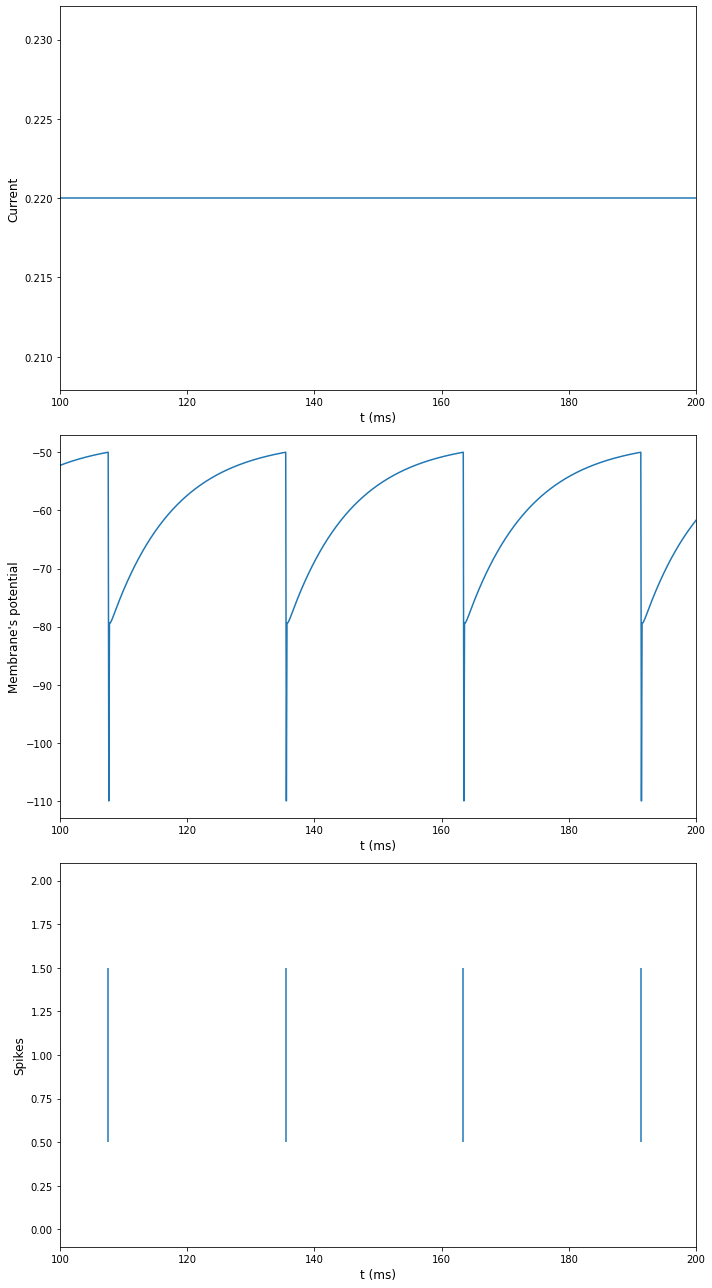

In [48]:
# Simulate for I_app = 0.22
sim_results = simulate_refractory_conductance(0.22)
plot_results(sim_results, t_min=100, t_max=200)

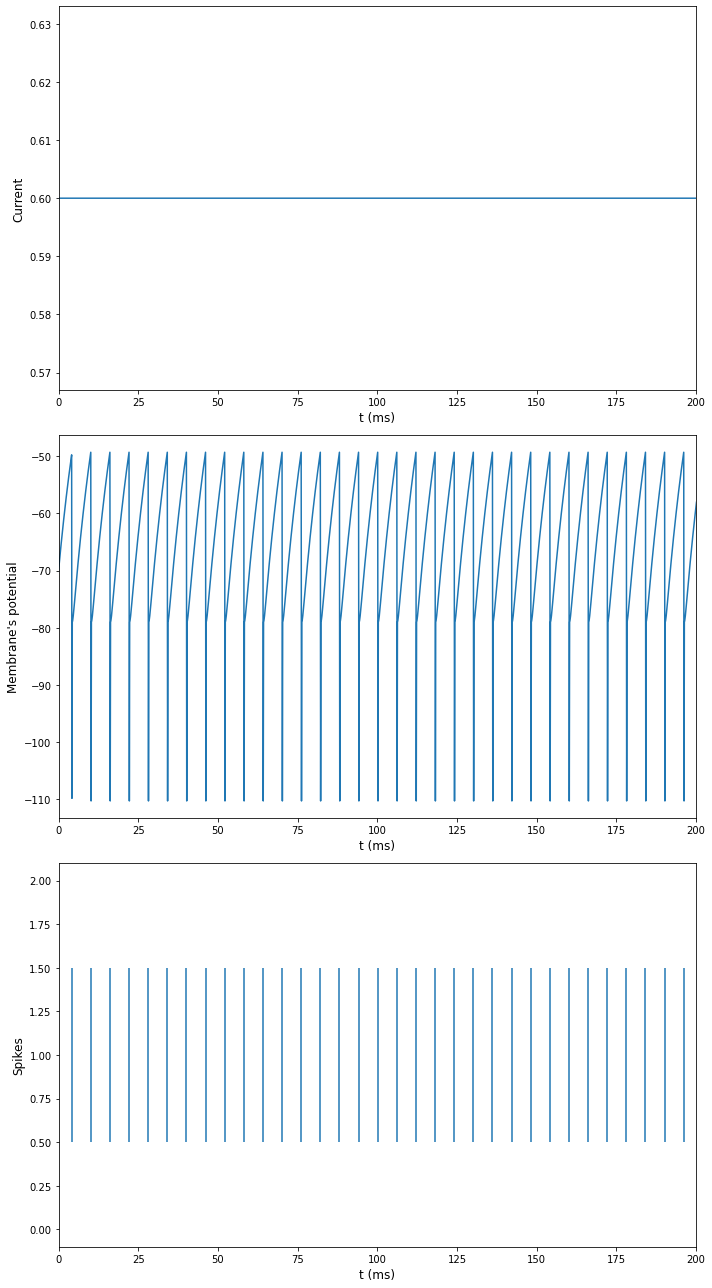

In [49]:
# Simulate for I_app = 0.6
sim_results = simulate_refractory_conductance(0.6)
plot_results(sim_results, t_min=0, t_max=200)

In [50]:
# Collect results for a range of currents
firing_rates_refractory_conductance = []
mean_potential_refractory_conductance = []
for I_app in I_range:
    sim_results = simulate_refractory_conductance(I_app)
    firing_rates_refractory_conductance.append(sim_results["firing_rate"])
    mean_potential_refractory_conductance.append(sim_results["mean_potential"])

#### Comparison of approaches

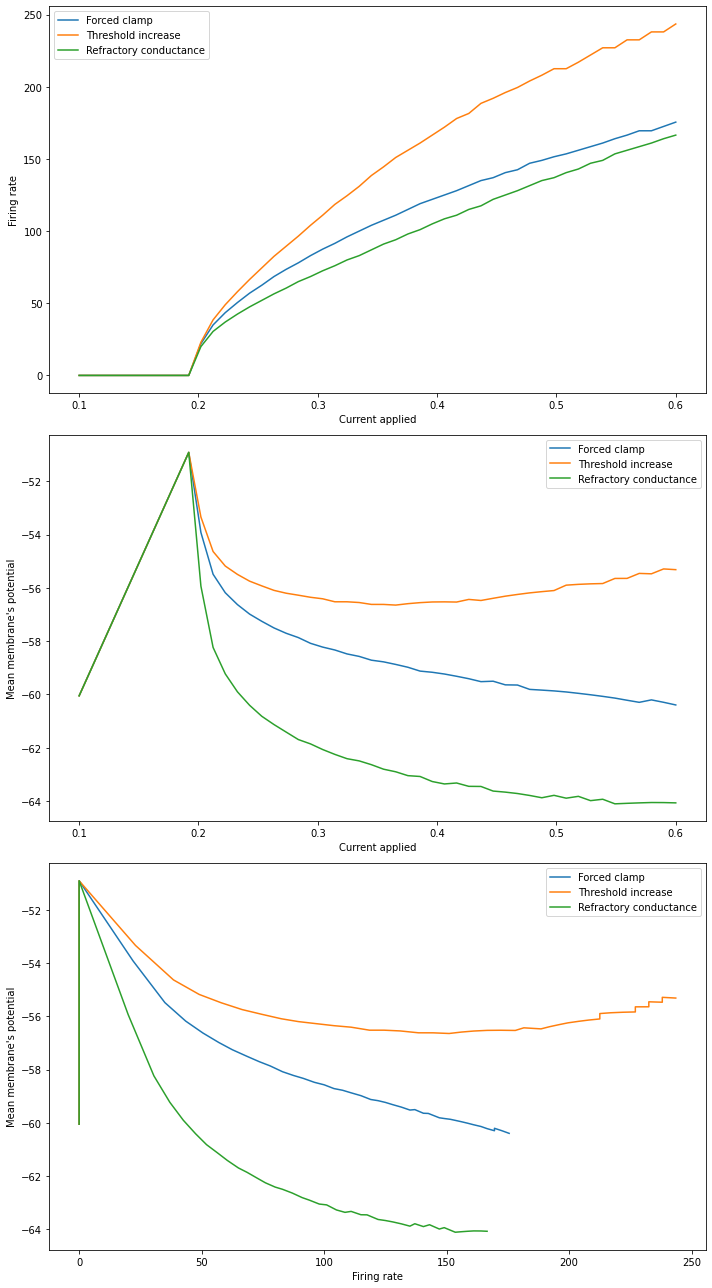

In [51]:
fig, ax = plt.subplots(3,1,figsize=(10,18))
ax[0].plot(I_range, firing_rates_forced_clamp, label="Forced clamp")
ax[0].plot(I_range, firing_rates_threshold_increase, label="Threshold increase")
ax[0].plot(I_range, firing_rates_refractory_conductance, label="Refractory conductance")
ax[0].legend()
ax[0].set_xlabel("Current applied")
ax[0].set_ylabel("Firing rate")
ax[1].plot(I_range, mean_potential_forced_clamp, label="Forced clamp")
ax[1].plot(I_range, mean_potential_threshold_increase, label="Threshold increase")
ax[1].plot(I_range, mean_potential_refractory_conductance, label="Refractory conductance")
ax[1].legend()
ax[1].set_xlabel("Current applied")
ax[1].set_ylabel("Mean membrane's potential")
ax[2].plot(firing_rates_forced_clamp, mean_potential_forced_clamp, label="Forced clamp")
ax[2].plot(firing_rates_threshold_increase, mean_potential_threshold_increase, label="Threshold increase")
ax[2].plot(firing_rates_refractory_conductance, mean_potential_refractory_conductance, label="Refractory conductance")
ax[2].legend()
ax[2].set_xlabel("Firing rate")
ax[2].set_ylabel("Mean membrane's potential")
plt.tight_layout()
plt.show()

##### Conclusions

**Firing rate as a function of applied current**
1. In three models, whenever the current is below a minimum value (around 200pA), the firing rate is 0. This is because, in those cases, the current is too weak to increase the membrane's potential beyond the spiking threshold. Whenever the current is higher than that minimum value, the firing rate is increasing with the level of current applied.

2. Of the three models, the threshold increase model has the highest sensitivity of the firing rate to the applied current. The firing rate in this model is higher than in the others for every current level beyond the minimum value to generate spikes.

3. In the three models the firing rate increase with respect to the applied current appears to be sublinear. This is, the positive slope of the curve appears to decrease as the current increases. This can be explained by the presence of the refractory period mechanisms in the models. These induce an upper limit in the firing rate (roughly 1 / duration of refractory period) and as the current increases the firing rate begins to saturate as it approaches such limit.

**Mean membrane's potential as a function of applied current**
1. In the three models, the mean membrane's potential increases linearly with the applied current as long as the latter is below the minimum level that generates spikes. This is expected, since at those levels, the current increases the mean potential at a constant rate, but it still remains below the spiking threshold. Moreover, for those values of current, the models are equivalent because in the absence of spikes their respective refractory mechanisms are not enforced.

2. In both the forced clamp and refractory conductance models, the mean potential is generally decreasing in the applied current (once it is beyond the minimum level to generate spikes). In the forced clamp model this can be explained by the refractory period mechanism which, after each spike, resets the membrane's potential to a relatively low level, $V_{reset}$, and holds it there for $\tau_{ref}$ ms. Thus, as the current increases (and with it the firing rate), these "reset and hold" events become more frequent, and overall the membrane's potential will remain more time of the trial at the low $V_{reset}$ value which leads to a lower average potential. A similar effect takes place in the refractory conductance model, since the abrupt increase in the refractory conductance, $G_{ref}$, after each spike, through it influence in the membrane's potential dynamics induces an abrupt and steep decrease in it to a low level (even lower than $V_{reset}$). As the current increases, and with it the firing rate, the membrane's potential experiences these sharp declines more frequently and, overall, spends more time of the trial in a relatively low value leading to a lower average potential.

3. In the threshold increase model, if the current is above the minimum value to generate spikes but below a critical value (around 350pA), the mean membrane's potential is decreasing with it. Once the current is above that crticial value, the mean potential becomes increasing in it. This relationship can be explained by the two mechanisms applied in the model after each spike. On one side, the membrane's potential resets at the relatively low value $V_{reset}$ and then starts to increase due to the applied current. On the other side, the spiking threshold abruptly increases to $V_{th}^{(max)}$ and then starts to decrease towards its baseline value, $V_{th}^{(0)}$. As the current increases, and with it the firing rate, there are two opposing effects: on one hand, the resets of the membrane's potential become more frequent and, since the reset value is relatively low, this tends to decrease the mean potential, but, on the other hand, the rate of increase of the membrane's potential is higher leading to higher values of the potential and with it a higher average potential. In the decreasing segment of the curve, the first effect is dominant and drives the decreasing relationship between mean potential and current. However, once the current is high enough (higher than the critical value mentioned above), it enables the membrane's potential to reach a higher threshold, since it increases more rapidly than the threshold, $V_{th}$, decreases. Then each time the current increases the spikes occur at a higher threshold and, overall, the membrane's potential is at higher values during more time of the trial leading to a higher average potential. 

**Mean membrane's potential as a function of firing rate**
1. In the three models, when the firing rate is zero (corresponding to an underlying current below the minimum level to generate spikes), there is no relationship between it and the mean membrane's potential, since in all of those cases the rate will be 0 irrespective of the current and the induced average potential. 
2. In both the forced clamp and refractory conductance models, the mean membrane's potential is decreasing in the firing rate (if the latter is positive). This is in line with the explanations from above. A higher firing rate implies that the potential is more frequently in lower values which implies a lower average value.
3. In the threshold increase model, if the firing rate is positive but below a critical value (around 175Hz), the mean membrane's potential is decreasing in it, but beyond this critical value, the relationship becomes increasing. This is also consistent with the explanation above, because once the firing rate is high enough (or, equivalently, the interspike interval low enough), the membrane's potential increases faster than the threshold decreases, and spikes occur at a higher threshold leading to a higher mean potential.

### Extensions of the LIF Model

We incorporate adaptation currents into the LIF model and assess their effect on the f-I curve.

#### Spike-rate adaptation conductance

The model with the adaptation current is described by the two differential equations: 

$$ C_m \dfrac{dV_m(t)}{dt} = G_L(E_L - V_m(t)) + G_{SRA}(t)(E_K - V_m(t))+I_{app} $$

$$ \dfrac{dG_{SRA}(t)}{dt} = \dfrac{-G_{SRA}(t)}{\tau_{SRA}} $$

And the spiking rule which sets $V_m = V_{reset}$ and $G_{SRA} = G_{SRA} + \Delta G_{SRA}$ whenever $V_m > V_{th}$

We use the following parameters values: $E_L=-75$, $V_{th}=-50$, $V_{reset}=-80$, $G_L=1/100$, $C_m=0.1$, $E_K=-80$, $\Delta G_{SRA}=0.001$, and $\tau_{SRA}=200$

And the initial values: $V_m(0)=E_L$ and $G_{SRA}(0)=0$

In [64]:
def update_V_m(prev_V_m, timestep, G_L, E_L, C_m, G_sra, E_K, I_app):   
    
    return prev_V_m + (timestep*(G_L*(E_L - prev_V_m) + G_sra*(E_K - prev_V_m) + I_app) / C_m)

def update_G_sra(prev_G_sra, timestep, tau_sra):
    return prev_G_sra - timestep*prev_G_sra/tau_sra

def generate_current_vector(I_app, t, constant, t_min, t_max):
    if constant:
        return np.zeros(len(t)) + I_app
    else:
        return np.where((t>=t_min) & (t<=t_max), I_app, 0)

def simulate(I_app, t_max=2000, timestep=0.1, G_L=(1/100), E_L=-75, 
             C_m=0.1, V_th=-50, V_reset=-80, E_K=-80, delta_G_sra=0.001,
             tau_sra=200, constant_current=True, current_t_min=None, 
             current_t_max=None):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    G_sra = np.zeros(len(t))
    V_m[0] = E_L
    G_sra[0] = 0
    I = generate_current_vector(I_app, t, constant_current, current_t_min, current_t_max)
    spikes = np.zeros(len(t)).astype(int)
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, G_sra[i-1], E_K, I[i])
        G_sra[i] = update_G_sra(G_sra[i-1], timestep, tau_sra)
        if V_m[i] > V_th:
            # There is a spike in this case
            spikes[i] = 1
            V_m[i] = V_reset
            G_sra[i] += delta_G_sra

    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "G_sra": G_sra,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "spike_times": t[spikes.astype(bool)],
            "firing_rate": firing_rate}

def plot_results(results_dict, t_min=100, t_max=300):
    fig, ax = plt.subplots(3,1, figsize=(10,18))
    ax[0].plot(results_dict["t"], results_dict["I"])
    ax[0].set_xlim((t_min, t_max))
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("Current", fontsize=12)
    ax[1].plot(results_dict["t"], results_dict["V_m"])
    ax[1].set_xlim((t_min, t_max))
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("Membrane's potential", fontsize=12)
    ax[2].plot(results_dict["t"], results_dict["G_sra"])
    ax[2].set_xlim((t_min, t_max))
    ax[2].set_xlabel("t (ms)", fontsize=12)
    ax[2].set_ylabel("Adaptation conductance", fontsize=12)
    plt.tight_layout()
    plt.show()    

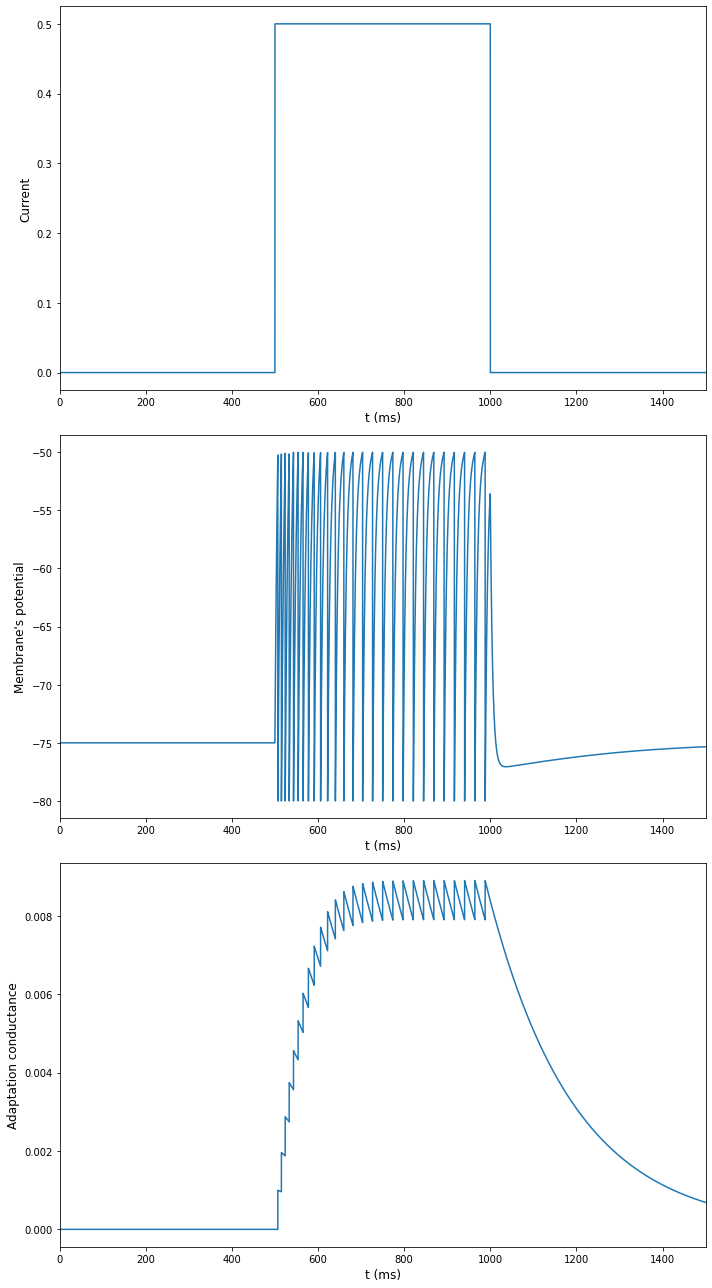

In [32]:
# Plot a 500pA current applied from 0.5s until 1.0s 
sim_results = simulate(0.5, t_max=1500, constant_current=False, current_t_min=500, current_t_max=1000)
plot_results(sim_results, t_min=0, t_max=1500)

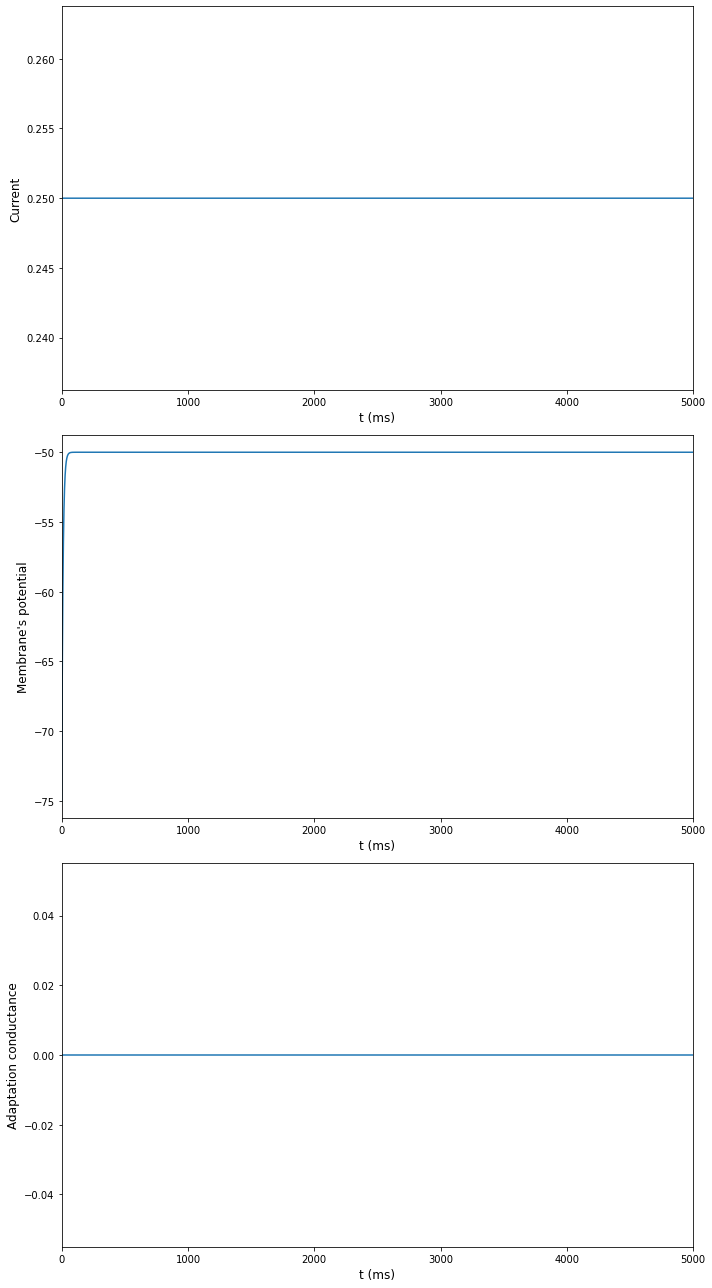

In [43]:
# Find numerically current which makes steady state firing rate 0
sim_results = simulate(0.25, t_max=5000, constant_current=True)
plot_results(sim_results, t_min=0, t_max=5000)

In [72]:
# Collect results for a range of currents
I_range = np.linspace(0.25, 1, 20)
initial_firing_rate = []
steady_state_firing_rate = []
for I_app in I_range:
    sim_results = simulate(I_app, t_max=5000, constant_current=True)
    if sim_results["firing_rate"] > 0:
        initial_ISI = sim_results["spike_times"][1] - sim_results["spike_times"][0]
        final_ISI = sim_results["spike_times"][-1] - sim_results["spike_times"][-2]
        initial_firing_rate.append(1000 / initial_ISI)
        steady_state_firing_rate.append(1000 / final_ISI)
    else:
        initial_firing_rate.append(0)
        steady_state_firing_rate.append(0)

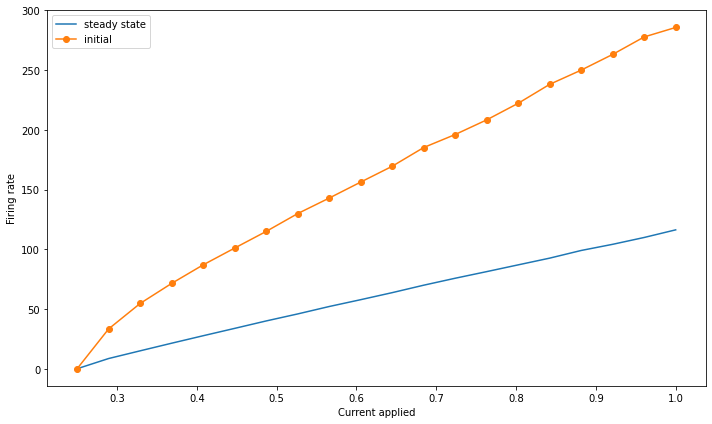

In [73]:
plt.figure(figsize=(10,6))
plt.plot(I_range, steady_state_firing_rate, label="steady state")
plt.plot(I_range, initial_firing_rate, marker="o", label="initial")
plt.xlabel("Current applied")
plt.ylabel("Firing rate")
plt.legend()
plt.tight_layout()
plt.show()

**Observations**
Whenever the external current is strong enough to produce spikes, the initial rate is greater then the steady state rate. Moreover, as the applied current increases, the gap between the initial and final rate increases as well. This is a consequence of the spike-rate adaptation mechanism introduced in the model. On each spike, the spike-rate adaptation conductance, $G_{SRA}$, increases incrementally by the small amount $\Delta G_{SRA}$. Hence its effect on the membrane's potential dynamics during the first spikes is negligible. However, as the spiking continues, $G_{SRA}$  starts to build up and to modulate the membrane's potential decreasing the firing rate. But this reduction of the firing rate, in turn, reduces the frequency of the increments of  $G_{SRA}$. Eventually, a temporal equilibrium (stady state) is reached where the firing rate stabilizes at a constant value which is lower than its initial values. Additionally, the SRA mechanism makes the steady state firing rate less sensitive to increases in the applied current (across trials) compared to the initial rate (where the effect of the SRA is absent) as noted by the smaller slope of the steady state f-I curve compared to the initial one.

#### AELIF Model

The Adaptive Exponential Leaky Integrate-and-Fire (AELIF) model is given by the differential equations:

$$ C_m \dfrac{dV_m(t)}{dt} = G_L(E_L - V_m(t) + \Delta_{th} exp(\frac{V_m(t) - V_{th}}{\Delta_{th}})) - I_{SRA}(t)+I_{app} $$

$$ \tau_{SRA} \dfrac{dI_{SRA}(t)}{dt} = a(V_m(t) - E_L) - I_{SRA}(t)$$

And the rules: 

$V_m = V_{reset}$ and $I_{SRA} = I_{SRA}+b$, whenever $V_m > V_{max}$

We use the following parameters values:

$ E_L = -75, V_{th} = -50, V_{max} = 100, V_{reset} = -80, \Delta_{th} = 2, G_L = 10, C_m = 100, a=2, b=20, \tau_{SRA}=200$

Note: given the above parametrization the current in the equation is expressed in pA, and not in nA as in the previous models. 

The initial values are:

$V(0)=E_L$ and $I_{SRA}=0$

In [141]:
def update_V_m(prev_V_m, timestep, G_L, E_L, C_m, delta_th, V_th, I_sra, I_app):   
    
    return prev_V_m + (timestep*(G_L*(E_L - prev_V_m + delta_th*np.exp((prev_V_m - V_th) / delta_th)) \
                                 - I_sra + I_app) / C_m)

def update_I_sra(prev_I_sra, timestep, tau_sra, a, V_m, E_L):
    return prev_I_sra + timestep*(a*(V_m - E_L) - prev_I_sra)/tau_sra

def simulate(I_app, t_max=2000, timestep=0.1, G_L=10, E_L=-75, 
             C_m=100, V_th=-50, V_reset=-80, delta_th=2, a=2, b=20,
             tau_sra=200, V_max=100, constant_current=True, current_t_min=None, 
             current_t_max=None):
    t = np.arange(0,t_max, timestep)
    V_m = np.zeros(len(t))
    I_sra = np.zeros(len(t))
    V_m[0] = E_L
    I_sra[0] = 0
    I = generate_current_vector(I_app, t, constant_current, current_t_min, current_t_max)
    spikes = np.zeros(len(t)).astype(int)
    V_m_above_max = np.zeros(len(t)).astype(int)
    in_spike = False
    for i in range(1,len(t)):
        V_m[i] = update_V_m(V_m[i-1], timestep, G_L, E_L, C_m, delta_th, V_th, I_sra[i-1], I[i])
        I_sra[i] = update_I_sra(I_sra[i-1], timestep, tau_sra, a, V_m[i-1], E_L)
        if V_m[i] > V_th and not in_spike:
            # There is a spike in this case
            spikes[i] = 1
            # The reset does not happen in this threshold
            in_spike = True
        if V_m[i] > V_max:
            V_m[i] = V_reset
            I_sra[i] = I_sra[i] + b
            V_m_above_max[i] = 1
            in_spike = False
    # Get firing rate in Hz
    firing_rate = 1000 * spikes.sum() / t_max
    return {"V_m": V_m,
            "I_sra": I_sra,
            "t": t,
            "I": I,
            "spike_train": spikes,
            "spike_times": t[spikes.astype(bool)],
            "firing_rate": firing_rate,
            "V_m_above_max": V_m_above_max}

def plot_results(results_dict, t_min=100, t_max=300):
    fig, ax = plt.subplots(3,1, figsize=(10,18))
    ax[0].plot(results_dict["t"], results_dict["I"])
    ax[0].set_xlim((t_min, t_max))
    ax[0].set_xlabel("t (ms)", fontsize=12)
    ax[0].set_ylabel("Current", fontsize=12)
    ax[1].plot(results_dict["t"], results_dict["V_m"])
    ax[1].set_xlim((t_min, t_max))
    ax[1].set_xlabel("t (ms)", fontsize=12)
    ax[1].set_ylabel("Membrane's potential", fontsize=12)
    ax[2].plot(results_dict["t"], results_dict["I_sra"])
    ax[2].set_xlim((t_min, t_max))
    ax[2].set_xlabel("t (ms)", fontsize=12)
    ax[2].set_ylabel("Adaptation current", fontsize=12)
    plt.tight_layout()
    plt.show()    

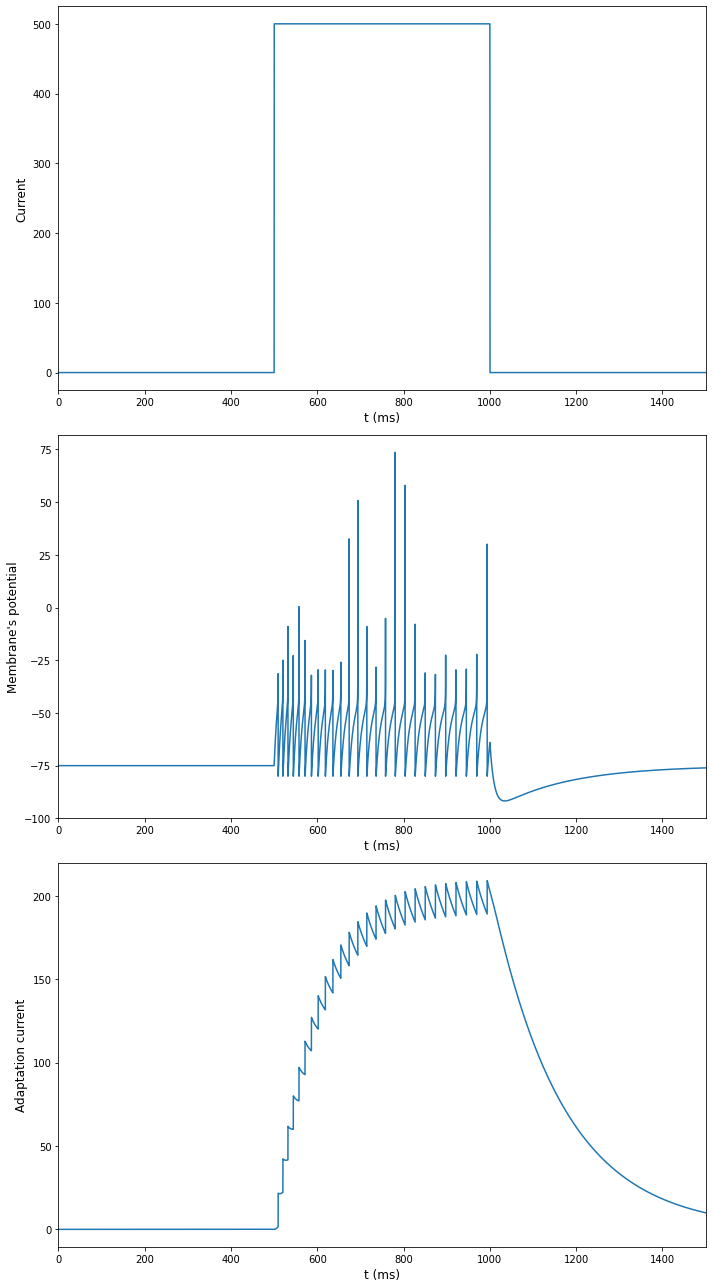

In [142]:
# Plot a 500pA current applied from 0.5s until 1.0s 
sim_results = simulate(500, t_max=1500, constant_current=False, current_t_min=500, current_t_max=1000)
plot_results(sim_results, t_min=0, t_max=1500)

In [148]:
# Note: on every spike, the potential reaches maximum due to exponential term
sim_results["V_m_above_max"].sum(), sim_results["spike_train"].sum()

(26, 26)

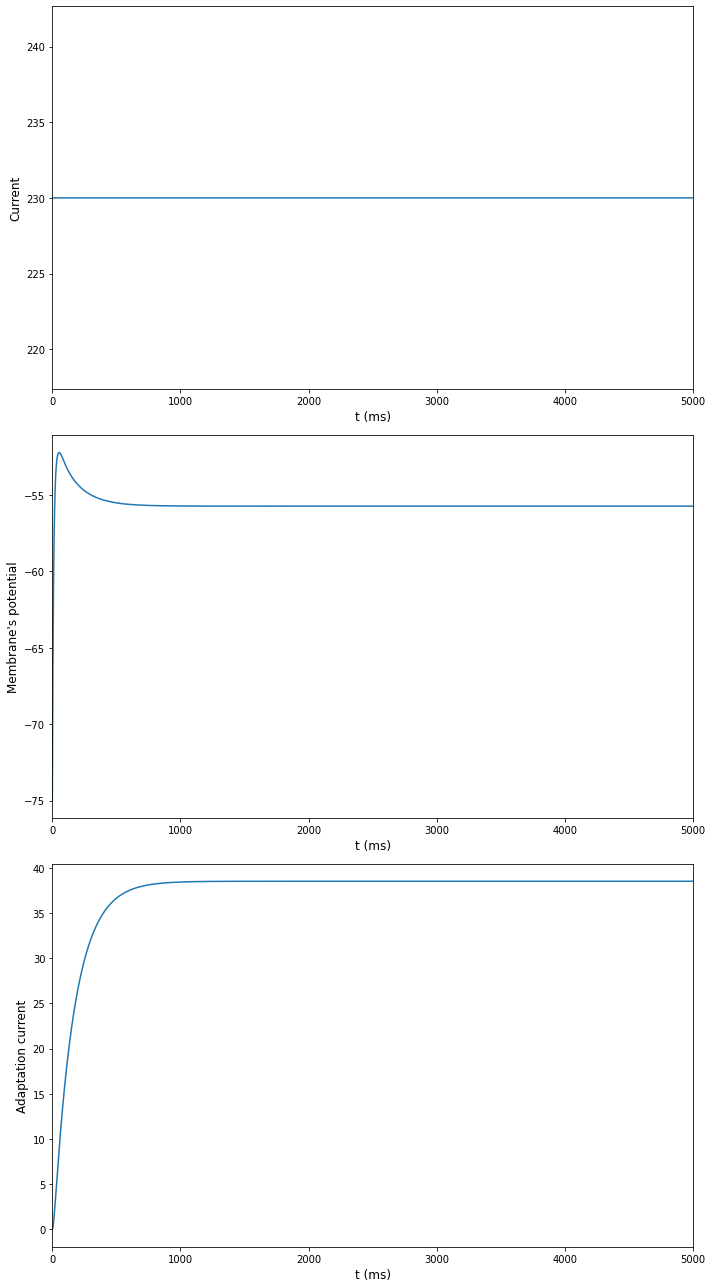

In [136]:
# Find numerically current which makes steady state firing rate 0
sim_results = simulate(230, t_max=5000, constant_current=True)
plot_results(sim_results, t_min=0, t_max=5000)

In [137]:
# Collect results for a range of currents
I_range = np.linspace(230, 1100, 20)
initial_firing_rate = []
steady_state_firing_rate = []
for I_app in I_range:
    sim_results = simulate(I_app, t_max=5000, constant_current=True)
    if sim_results["spike_train"].sum() > 1:
        initial_ISI = sim_results["spike_times"][1] - sim_results["spike_times"][0]
        final_ISI = sim_results["spike_times"][-1] - sim_results["spike_times"][-2]
        initial_firing_rate.append(1000 / initial_ISI)
        steady_state_firing_rate.append(1000 / final_ISI)
    else:
        initial_firing_rate.append(0)
        steady_state_firing_rate.append(0)

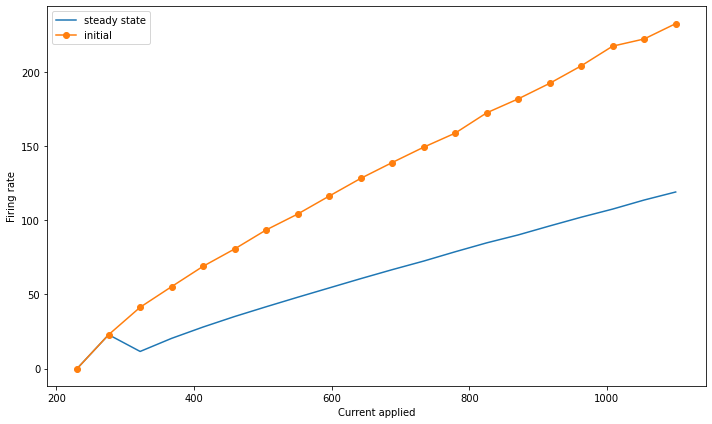

In [138]:
plt.figure(figsize=(10,6))
plt.plot(I_range, steady_state_firing_rate, label="steady state")
plt.plot(I_range, initial_firing_rate, marker="o", label="initial")
plt.xlabel("Current applied")
plt.ylabel("Firing rate")
plt.legend()
plt.tight_layout()
plt.show()

**Observations:** Similarly to the SRA model, we note that the initial firing rate is larger than the steady state rate, and as the current applied increases, the gap becomes wider. The reason for this is similar than in the previous model, as the AELIF also has a spike-rate adaptation mechanism via the SRA current, $I_{SRA}$. In particular, due to the exponential term in the membrane's potential differential equation, on every spike (every time $V_m > V_{th}$), the membrane's increases rapidly to reach its maximum value, $V_{max}$. Moreover, every time the membrane's potential reaches $V_{max}$, $I_{SRA}$ experiences an instant increment by $b$. Thus, each spike leads to a small increment in $I_{SRA}$ which at the beginning of the trial have a negligible effect on the firing rate, but as the increments build up, $I_{SRA}$ starts modulating the firing rate as in the previous model. Hence the gap between the steady state and the initial rates.

Note that this model in some senses generalizes the LIF model with the SRA since it enables the exponential increase in the potential during a spike along with the firing rate adaptation.

## References

Miller, Paul. An introductory course in computational neuroscience. MIT Press, 2018.